# Transfer Learning with Tensorflow Part 2: Fine-Tuning (With functional API)

In [ ]:
!nvidia-smi

Mon Jul 25 21:37:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-25 21:37:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-25 21:37:18 (111 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Load Data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2022-07-25 21:37:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   209MB/s    in 0.8s    

2022-07-25 21:37:22 (209 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories we have

walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [ ]:
# Create train and test data

train_dir= '10_food_classes_10_percent/train'
test_dir= '10_food_classes_10_percent/test'

In [ ]:
import tensorflow as tf

In [ ]:
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical')

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Visualizing Data

In [ ]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

## Model 0 - Baseline
* 10% of the training data
* No preprocessing
* Feature extraction EffcientNetB0

In [ ]:
# Import EfficientNetB0 model withgout output layer
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base model
base_model.trainable = False


inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# x = tf.keras.layers.experimental.preprocessing.Rescaling()

x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name='globa_average_pooling_layer')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

model_0 = tf.keras.Model(inputs, outputs)

# Compiling
model_0.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

#Fitting model_0
model_0_history = model_0.fit(train_data_10_percent,
                              steps_per_epoch=len(train_data_10_percent),
                              epochs=5,
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                     experiment_name='10_percent')])

16719872/16705208 [==============================] - 0s 0us/step
Saving TensorBoard log files to: transfer_learning/10_percent/20220725-213733
Epoch 1/5
24/24 [==============================] - 21s 232ms/step - loss: 1.8892 - accuracy: 0.4120 - val_loss: 1.3321 - val_accuracy: 0.7220
Epoch 2/5
24/24 [==============================] - 5s 187ms/step - loss: 1.1404 - accuracy: 0.7480 - val_loss: 0.9289 - val_accuracy: 0.8059
Epoch 3/5
24/24 [==============================] - 5s 185ms/step - loss: 0.8386 - accuracy: 0.7960 - val_loss: 0.7522 - val_accuracy: 0.8207
Epoch 4/5
24/24 [==============================] - 4s 150ms/step - loss: 0.6849 - accuracy: 0.8507 - val_loss: 0.6542 - val_accuracy: 0.8388
Epoch 5/5
24/24 [==============================] - 4s 149ms/step - loss: 0.5871 - accuracy: 0.8667 - val_loss: 0.5784 - val_accuracy: 0.8503


In [ ]:
# Evaluate on full test data
model_0.evaluate(test_data)

79/79 [==============================] - 6s 76ms/step - loss: 0.6116 - accuracy: 0.8352


[0.611613929271698, 0.8352000117301941]

83% - pretty ok

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 globa_average_pooling_layer  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


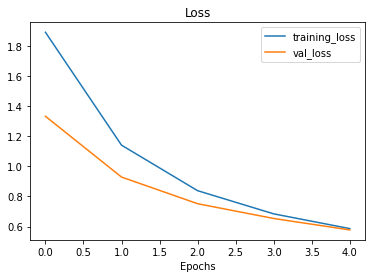

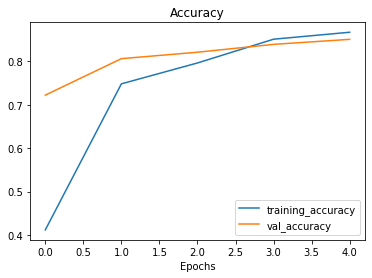

In [ ]:
plot_loss_curves(model_0_history)

## Model 1
* <font color='red'>1%</font> of the training data
* <font color='red'>Data augmentation</font>
* Feature extraction EffcientNetB0

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

--2022-07-25 21:38:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 172.253.63.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   167MB/s    in 0.8s    

2022-07-25 21:38:26 (167 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
train_1_percent_dir = '10_food_classes_1_percent/train'
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_1_percent_dir,
                                                                           image_size=(224, 224),
                                                                           label_mode='categorical')

Found 70 files belonging to 10 classes.


In [ ]:
data_augmentation = tf.keras.models.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomRotation(0.2),
], name='data_augmentation')

#### Visualizing augmented images

(-0.5, 406.5, 489.5, -0.5)

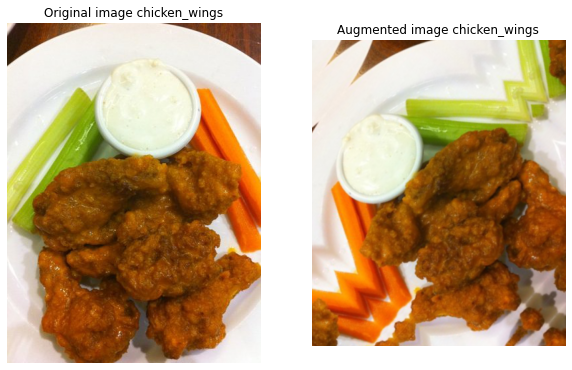

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

# Choosing image
random_class = random.choice(train_data_1_percent.class_names)
path_to_dir = train_1_percent_dir + '/' + random_class

random_image = random.choice(os.listdir(path_to_dir))
path_to_image = path_to_dir + '/' + random_image


# Importing and showing image
target_image = mpimg.imread(path_to_image)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(target_image)
plt.title(f'Original image {random_class}')
plt.axis(False)


# Augmenting image
aug_img = data_augmentation(target_image, training=True)

plt.subplot(1, 2, 2)
plt.imshow(aug_img/255.)
plt.title(f'Augmented image {random_class}')
plt.axis(False)

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Input Layer
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')
# Augmentation Layer
x = data_augmentation(inputs, training=True)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
output = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

model_1 = tf.keras.Model(inputs, output)


In [ ]:
model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

model_1_history = model_1.fit(train_data_1_percent,
                              steps_per_epoch=len(train_data_1_percent),
                              epochs=5,
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                    experiment_name='1_percent')])

Saving TensorBoard log files to: transfer_learning/1_percent/20220725-213831
Epoch 1/5
3/3 [==============================] - 20s 7s/step - loss: 2.4158 - accuracy: 0.0714 - val_loss: 2.2572 - val_accuracy: 0.1349
Epoch 2/5
3/3 [==============================] - 11s 6s/step - loss: 2.2093 - accuracy: 0.2000 - val_loss: 2.1666 - val_accuracy: 0.1941
Epoch 3/5
3/3 [==============================] - 11s 5s/step - loss: 1.9732 - accuracy: 0.3429 - val_loss: 2.0633 - val_accuracy: 0.2747
Epoch 4/5
3/3 [==============================] - 11s 5s/step - loss: 1.8629 - accuracy: 0.4857 - val_loss: 1.9712 - val_accuracy: 0.3536
Epoch 5/5
3/3 [==============================] - 11s 5s/step - loss: 1.7294 - accuracy: 0.6429 - val_loss: 1.8971 - val_accuracy: 0.3914


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
model_1.evaluate(test_data)

79/79 [==============================] - 20s 249ms/step - loss: 1.8985 - accuracy: 0.3852


[1.8984534740447998, 0.38519999384880066]

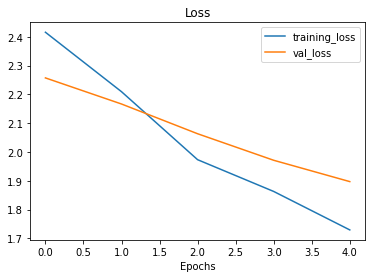

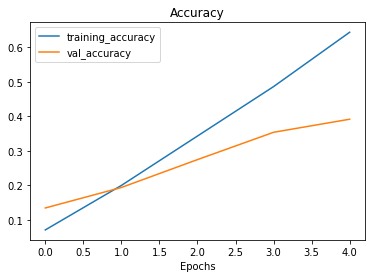

In [ ]:
plot_loss_curves(model_1_history)

#### 40% is not so good, but we have to remember that this is only 1% of the dataset

## Model 2
* <font color='red'>10%</font> of the training data
* Data augmentation
* Feature extraction EffcientNetB0

In [ ]:
data_augmentation_2 = tf.keras.models.Sequential([                                                
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomRotation(0.2)
])

data_augmentation_2.build((None, 224, 224, 3))
data_augmentation_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_height_1 (RandomHeig  (None, 224, 224, 3)      0         
 ht)                                                             
                                                                 
 random_width_1 (RandomWidth  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 random_zoom_1 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                        

In [ ]:
backbone = tf.keras.applications.EfficientNetB0(include_top=False)
backbone.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation_2(inputs, training=True)
x = backbone(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool (GlobalAver  (None, 1280)             0         
 agePooling2D)                                                   
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
____________________________________________

In [ ]:
checkpoint_path = 'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq='epoch',
                                                         verbose=1)

In [ ]:
model_2_history = model_2.fit(train_data_10_percent,
                  steps_per_epoch=len(train_data_10_percent),
                  epochs=5,
                  validation_data=test_data,
                  validation_steps=int(0.25 * len(test_data)),
                  callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                         experiment_name='10_percent_data_aug'),
                             checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220725-214023
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0590 - accuracy: 0.3307
Epoch 1: val_loss improved from inf to 1.63768, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 21s 587ms/step - loss: 2.0590 - accuracy: 0.3307 - val_loss: 1.6377 - val_accuracy: 0.5872
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3727 - accuracy: 0.6587
Epoch 2: val_loss improved from 1.63768 to 1.21770, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 468ms/step - loss: 1.3727 - accuracy: 0.6587 - val_loss: 1.2177 - val_accuracy: 0.7138
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0699 - accuracy: 0.7387
Epoch 3: val_loss improved from 1.21770 to 0.98774, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [=

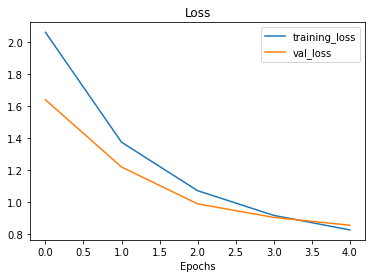

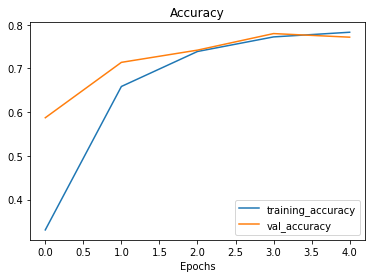

In [ ]:
plot_loss_curves(model_2_history)

#### Validation accuracy stays at 75% - better but still not enough.

## Model 3
* 10% of the training data
* Data augmentation
* <font color='red'>Fine-tuning EffcientNetB0 - top 10 layers unfrozen</font>

In [ ]:
for layer in model_2.layers:
  print(layer.trainable, layer)

True <keras.engine.input_layer.InputLayer object at 0x7f9271f398d0>
True <keras.engine.sequential.Sequential object at 0x7f9271f1a750>
False <keras.engine.functional.Functional object at 0x7f9271a16cd0>
True <keras.layers.pooling.GlobalAveragePooling2D object at 0x7f9271ada2d0>
True <keras.layers.core.dense.Dense object at 0x7f9271986350>


In [ ]:
for layer in model_2.layers[2].layers:
  print(layer.trainable, layer)

False <keras.engine.input_layer.InputLayer object at 0x7f9271ec0390>
False <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f9275230790>
False <keras.layers.preprocessing.normalization.Normalization object at 0x7f9271f39310>
False <keras.layers.convolutional.ZeroPadding2D object at 0x7f9271f1d750>
False <keras.layers.convolutional.Conv2D object at 0x7f9271ec2290>
False <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f9271f2abd0>
False <keras.layers.core.activation.Activation object at 0x7f9271ecf750>
False <keras.layers.convolutional.DepthwiseConv2D object at 0x7f9271edd850>
False <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f9271ee3c50>
False <keras.layers.core.activation.Activation object at 0x7f9271ed8850>
False <keras.layers.pooling.GlobalAveragePooling2D object at 0x7f9271f39350>
False <keras.layers.core.reshape.Reshape object at 0x7f9271efaa10>
False <keras.layers.convolutional.Conv2D object 

In [ ]:
backbone.trainable = True

for layer in backbone.layers[:-10]:
  layer.trainable = False

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
print('...')
for layer in model_2.layers[2].layers[-30:]:
  print(layer.trainable, layer)

...
False <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f9271c78cd0>
False <keras.layers.core.activation.Activation object at 0x7f9271ad1b10>
False <keras.layers.convolutional.DepthwiseConv2D object at 0x7f9271ae2410>
False <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f9271b1cd10>
False <keras.layers.core.activation.Activation object at 0x7f9271af5050>
False <keras.layers.pooling.GlobalAveragePooling2D object at 0x7f9271a8c850>
False <keras.layers.core.reshape.Reshape object at 0x7f9271b1c090>
False <keras.layers.convolutional.Conv2D object at 0x7f9271a8cc10>
False <keras.layers.convolutional.Conv2D object at 0x7f9271ae8e10>
False <keras.layers.merge.Multiply object at 0x7f9271a9fbd0>
False <keras.layers.convolutional.Conv2D object at 0x7f9271aed190>
False <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f9271afc6d0>
False <keras.layers.core.dropout.Dropout object at 0x7f9271aabe10>
Fals

In [ ]:
fine_tune_epochs = 5 + 5

model_3_history = model_2.fit(train_data_10_percent,
                              steps_per_epoch=len(train_data_10_percent),
                              epochs = fine_tune_epochs,
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              initial_epoch=model_2_history.epoch[-1],
                              callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                     experiment_name='10_percent_fine_tuning')])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tuning/20220725-214145
Epoch 5/10
24/24 [==============================] - 20s 540ms/step - loss: 0.6943 - accuracy: 0.8133 - val_loss: 0.7471 - val_accuracy: 0.7500
Epoch 6/10
24/24 [==============================] - 10s 402ms/step - loss: 0.5994 - accuracy: 0.8333 - val_loss: 0.6738 - val_accuracy: 0.7895
Epoch 7/10
24/24 [==============================] - 11s 454ms/step - loss: 0.5236 - accuracy: 0.8347 - val_loss: 0.6291 - val_accuracy: 0.7895
Epoch 8/10
24/24 [==============================] - 8s 326ms/step - loss: 0.4401 - accuracy: 0.8720 - val_loss: 0.6275 - val_accuracy: 0.7878
Epoch 9/10
24/24 [==============================] - 9s 367ms/step - loss: 0.4275 - accuracy: 0.8653 - val_loss: 0.5512 - val_accuracy: 0.8141
Epoch 10/10
24/24 [==============================] - 11s 436ms/step - loss: 0.3832 - accuracy: 0.8787 - val_loss: 0.6163 - val_accuracy: 0.7944


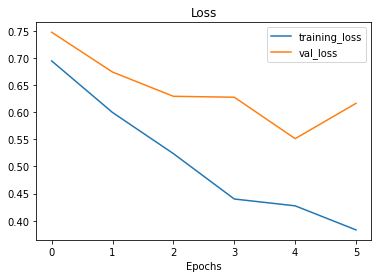

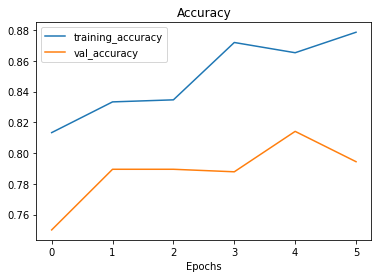

In [ ]:
plot_loss_curves(model_3_history)

In [ ]:
def compare_histories(original_history, new_history, initial_epochs=5):
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  # Plots
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Test Accuracy')
  plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label='Start Fine Tuning')
  plt.legend()
  plt.title('Training and validation accuracy')

  
  plt.subplot(1, 2, 2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Test Loss')
  plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label='Start Fine Tuning')
  plt.legend()
  plt.title('Training and validation Loss')

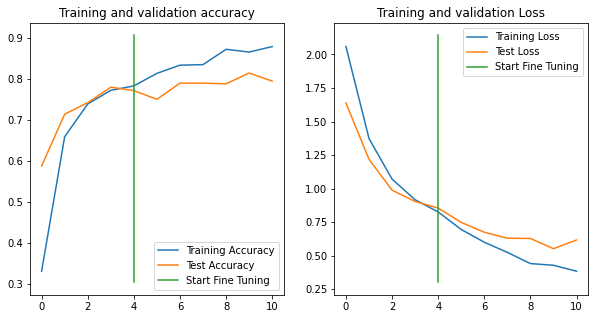

In [ ]:
compare_histories(model_2_history, model_3_history)

## Model 4
* <font color='red'>100%</font> of the training data
* Data augmentation
* Fine-tuning EffcientNetB0 - top 10 layers unfrozen

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data('10_food_classes_all_data.zip')

--2022-07-25 21:54:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.0.48, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.0.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   129MB/s    in 4.1s    

2022-07-25 21:54:54 (121 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
train_dir_all_data = '10_food_classes_all_data/train'
walk_through_dir('10_food_classes_all_data/')

There are 2 directories and 0 images in '10_food_classes_all_data/'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'

In [ ]:
train_data_all = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                     label_mode='categorical',
                                                                     image_size=(224, 224))

Found 7500 files belonging to 10 classes.


In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 14s 166ms/step - loss: 0.8532 - accuracy: 0.7680


[0.853211522102356, 0.7680000066757202]

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool (GlobalAver  (None, 1280)             0         
 agePooling2D)                                                   
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-trainable params: 3,156,339
___________________________________________

In [ ]:
print('...')
for layer in model_2.layers[2].layers[-30:]:
  print(layer.trainable)

...
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True


In [ ]:
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=['accuracy'])

model_4_history = model_2.fit(train_data_all,
                              steps_per_epoch=len(train_data_all),
                              epochs=fine_tune_epochs,
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              initial_epoch=model_2_history.epoch[-1],
                              callbacks=[create_tensorboard_callback(dir_name='transfer-learning',
                                                                     experiment_name='all_10_classes_fine_tuning')])

Saving TensorBoard log files to: transfer-learning/all_10_classes_fine_tuning/20220725-222623


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 5/10
235/235 [==============================] - 51s 193ms/step - loss: 0.7409 - accuracy: 0.7617 - val_loss: 0.5403 - val_accuracy: 0.8076
Epoch 6/10
235/235 [==============================] - 43s 182ms/step - loss: 0.5912 - accuracy: 0.8061 - val_loss: 0.4570 - val_accuracy: 0.8372
Epoch 7/10
235/235 [==============================] - 39s 164ms/step - loss: 0.5402 - accuracy: 0.8251 - val_loss: 0.4655 - val_accuracy: 0.8503
Epoch 8/10
235/235 [==============================] - 36s 150ms/step - loss: 0.4811 - accuracy: 0.8429 - val_loss: 0.3916 - val_accuracy: 0.8799
Epoch 9/10
235/235 [==============================] - 38s 159ms/step - loss: 0.4571 - accuracy: 0.8524 - val_loss: 0.4161 - val_accuracy: 0.8602
Epoch 10/10
235/235 [==============================] - 35s 147ms/step - loss: 0.4285 - accuracy: 0.8633 - val_loss: 0.3877 - val_accuracy: 0.8618


In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 11s 137ms/step - loss: 0.4064 - accuracy: 0.8728


[0.4064083397388458, 0.8727999925613403]

### 87% is our best score!

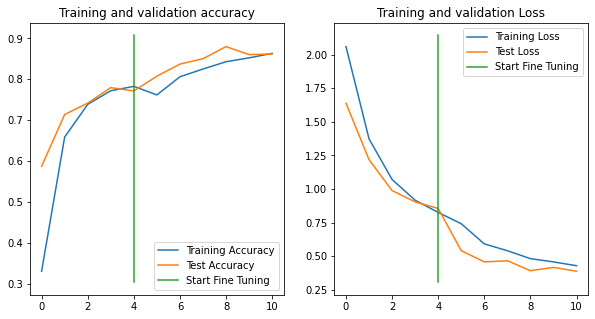

In [ ]:
compare_histories(model_2_history, model_4_history, initial_epochs=5)

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
--name 'Transfer learning Experiments with 10 Food101 Classes' \
--description 'A series of different transfer learning experiments with varying amount of data and fine-tuning' \
--one_shot

## My tensorboard experiments are available here!
https://tensorboard.dev/experiment/igGel0DSRTqq2omyfNAyvQ/